# Try out the GSMT simulator

In [1]:
# try it out
import numpy as np
import matplotlib.pyplot as plt
import zosapi
zos = zosapi.App()
from gsmt import sim_params,filters,tmt_conf,sim_gsmt_jones_pupil
from hcipy import *

In [2]:
sim_params['wavelength'] = filters['I'] * 1e-6
sim_params['order'] = 6
sim_params['npix_pupil'] = 1024
sim_params['segment variation'] = True

wfout = sim_gsmt_jones_pupil(sim_params, tmt_conf)

norm fov =  [0. 0.]
base ray shape  (4, 1048576)
tracing with global coordinates
tracing with global coordinates
tracing with global coordinates
1 Raysets traced through 3 surfaces


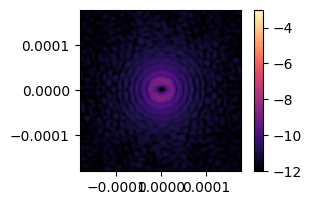

In [3]:
imshow_field(np.log10(wfout),vmin=-12,vmax=-3)
plt.colorbar()

In [2]:
from gsmt import create_tmt_aperture
array = create_tmt_aperture()

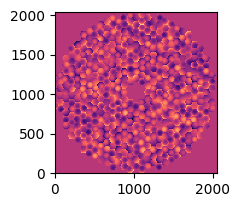

In [3]:
plt.imshow(array)

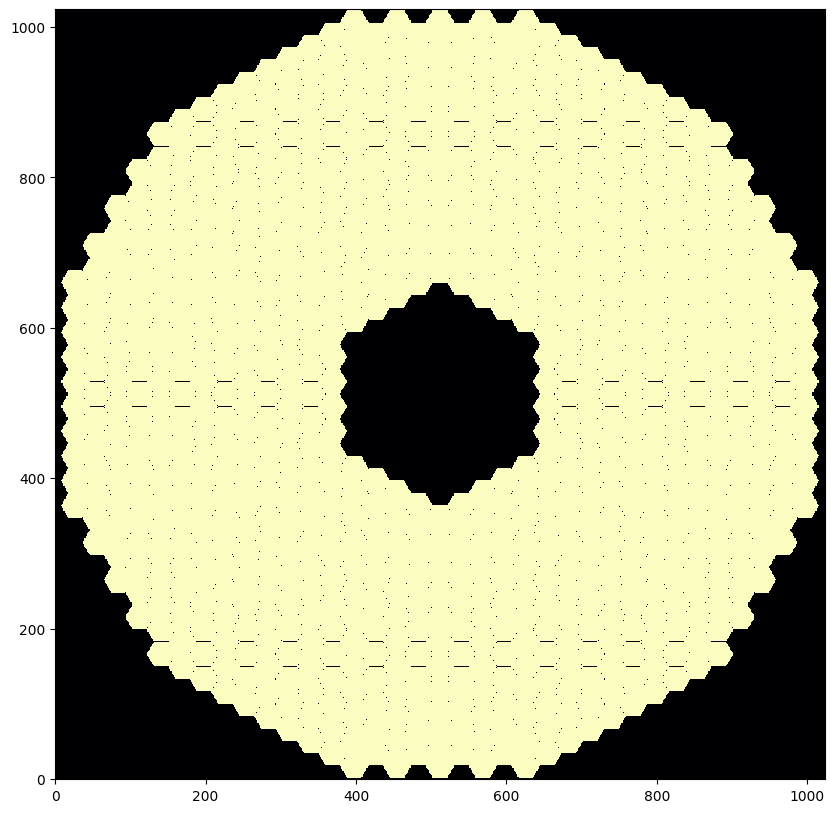

In [35]:
from hcipy import *
grid = make_pupil_grid(1024,1)
elt_aperture = evaluate_supersampled(make_elt_aperture(normalized=True,with_spiders=False),grid,1)
plt.figure(figsize=[10,10])
plt.imshow(elt_aperture.shaped)
plt.show()

In [5]:
from importlib import reload
import gsmt
reload(gsmt)
from gsmt import create_elt_aperture_and_phase
elt,aber = create_elt_aperture_and_phase(npix=1024)

In [6]:
grid = make_pupil_grid(1024,elt_conf['D_tel'])
elt_aper = Field(elt,grid)

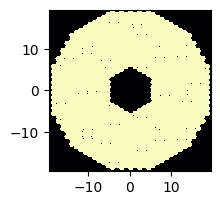

In [8]:
imshow_field(elt_aper)